In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv


In [2]:
import cv2
import gc
import albumentations as A
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import time


In [3]:


dataset = pd.read_csv('../input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')
dataset.columns = ['emotion', 'Usage', 'pixels']
test_dataset  = dataset.loc[dataset["Usage"] == 'PublicTest',['emotion','pixels']]
train_dataset = dataset.loc[dataset["Usage"] == 'Training', ['emotion', 'pixels']]
validation_dataset = dataset.loc[dataset["Usage"] == 'PrivateTest', ['emotion', 'pixels']]

In [4]:
def pixels_to_array(pixels):
    array = np.array(pixels.split(),'uint8')
    return array

def image_reshape(data):
    image = np.reshape(data['pixels'].to_list(),(data.shape[0],48,48,1))
    image = np.repeat(image, 3, -1)
    return image

In [5]:

train_dataset['pixels'] = train_dataset['pixels'].apply(pixels_to_array)
test_dataset['pixels']  = test_dataset['pixels'].apply(pixels_to_array)
validation_dataset['pixels'] = validation_dataset['pixels'].apply(pixels_to_array)

print("Train:")
print(type(train_dataset['pixels']))
print(train_dataset.shape)

print("Validation:")
print(type(validation_dataset['pixels']))
print(validation_dataset.shape)

print("Test:")
print(type(test_dataset['pixels']))
print(test_dataset.shape)


X_train = image_reshape(train_dataset)
y_train = train_dataset['emotion']
print(X_train.shape)

X_test = image_reshape(test_dataset)
y_test = test_dataset['emotion']
print(X_test.shape)

X_val = image_reshape(validation_dataset)
y_val = validation_dataset['emotion']
print(X_val.shape)
del dataset
gc.collect()

Train:
<class 'pandas.core.series.Series'>
(28709, 2)
Validation:
<class 'pandas.core.series.Series'>
(3589, 2)
Test:
<class 'pandas.core.series.Series'>
(3589, 2)
(28709, 48, 48, 3)
(3589, 48, 48, 3)
(3589, 48, 48, 3)


0

In [6]:
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

In [7]:
def TakeDir(Dir, Data, y):
    numbers_name = np.arange(1,1000000)
    for i in range(len(Data)):
        namefile = "Data_"+ str(numbers_name[i]) +".jpg"
        cv2.imwrite(os.path.join(Dir,str(y[i]),namefile), Data[i])

In [8]:
dataset_dir = "./dataset"
treino_dir = "./dataset/train"
val_dir = "./dataset/validation"
test_dir = "./dataset/test"

os.makedirs(dataset_dir,exist_ok=True)
os.makedirs(treino_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

labels = [0,1,2,3,4,5,6]

for label in labels:
  os.makedirs(os.path.join(treino_dir,str(label)),exist_ok=True)
  os.makedirs(os.path.join(val_dir,str(label)),exist_ok=True)
  os.makedirs(os.path.join(test_dir,str(label)),exist_ok=True)

numbers_name = np.arange(1,1000000)

TakeDir(treino_dir, X_train, y_train)
TakeDir(val_dir, X_val, y_val)
TakeDir(test_dir, X_test, y_test)

In [9]:
def Plot(dataset):
    plt.figure(figsize = (10,8))
    emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
    emotion_prop = (dataset.emotion.value_counts() / len(dataset)).to_frame().sort_index(ascending=True)
    plt.bar(x=emotions, height=emotion_prop['emotion'])    


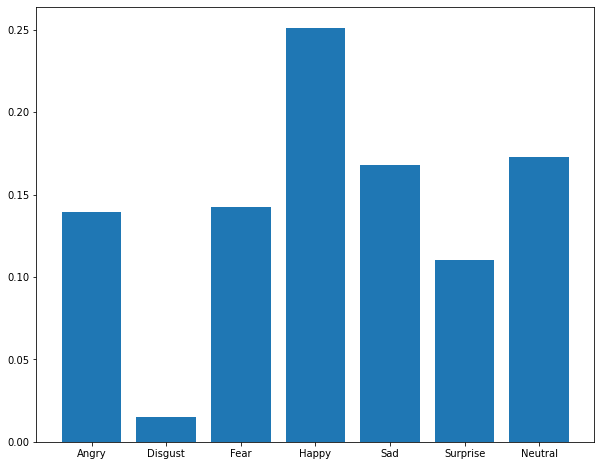

In [10]:
Plot(train_dataset)

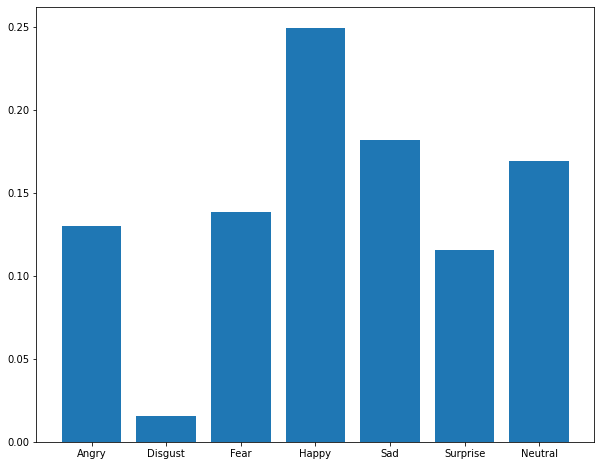

In [11]:
Plot(test_dataset)

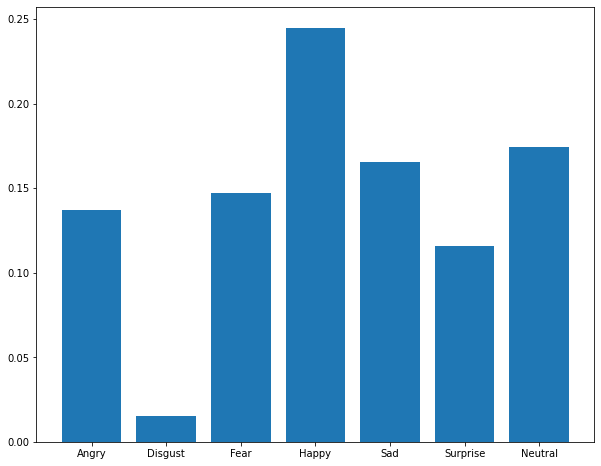

In [12]:
Plot(validation_dataset)

In [13]:
def get_training_augmentation():
    train_transform = [  
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0.4, shift_limit=0.4, p=1, border_mode= cv2.BORDER_REPLICATE),
        A.Perspective(p=0.6),
        A.Affine(p=0.5, scale= 0.9, rotate = 0.5, fit_output= True),
        A.GaussNoise(p=0.5),
        A.Sharpen(p=0.5),
    ]

    return A.Compose(train_transform)
    

In [14]:
def data_augmentation_from_directory(data_path, XGenerate):
    transform = get_training_augmentation()
    
    for folder in tqdm(data_path):
        FolofLab = [os.path.join(folder, name) for name in os.listdir(folder)]
        f = [b for b in FolofLab if os.path.isfile(b)]
        
        for pathtoimg in f:
            img = cv2.imread(pathtoimg)[:,:,::-1]
        
        for pathtoimg in f:
            img = cv2.imread(pathtoimg)[:,:,::-1]
            
            for i in range(XGenerate):
                augment = transform(image = img)
                aug_img = augment['image']
                name_img = 'Aug_{}.jpg'.format(random.randint(1,100000))
                cv2.imwrite(os.path.join(folder, name_img), aug_img)

In [15]:
def AugmentateTrain_with_specific_class(Directory, Label, XDirectory, specificLabel, XspecificLable):
    labels = Label
    
    data_path = []
    
    for label in labels:
        data_path.append(os.path.join(Directory, str(label)))
    data_augmentation_from_directory(data_path, XGenerate = XDirectory)
    
    data_path = []
    for label in specificLabel:
        data_path.append(os.path.join(Directory, str(label)))
    data_augmentation_from_directory(data_path, XGenerate = XDirectory)

In [16]:
ls

__notebook__.ipynb  dataset/


In [17]:
!mkdir './dataset/train_augmented'

In [18]:
!cp -r './dataset/train/.' './dataset/train_augmented'

In [19]:
time.sleep(360)

In [20]:
AugmentateTrain_with_specific_class('./dataset/train_augmented', [0,2,3,4,5,6], 3, [1],6)

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


In [21]:
ls -la

total 72
drwxr-xr-x 3 root root  4096 Mar 16 10:43 ./
drwxr-xr-x 6 root root  4096 Mar 16 10:42 ../
---------- 1 root root 59049 Mar 16 10:51 __notebook__.ipynb
drwxr-xr-x 6 root root  4096 Mar 16 10:43 dataset/


In [22]:
cd dataset

/kaggle/working/dataset


In [23]:
ls -la

total 24
drwxr-xr-x 6 root root 4096 Mar 16 10:43 ./
drwxr-xr-x 3 root root 4096 Mar 16 10:43 ../
drwxr-xr-x 9 root root 4096 Mar 16 10:43 test/
drwxr-xr-x 9 root root 4096 Mar 16 10:43 train/
drwxr-xr-x 9 root root 4096 Mar 16 10:43 train_augmented/
drwxr-xr-x 9 root root 4096 Mar 16 10:43 validation/


In [24]:
cd train_augmented

/kaggle/working/dataset/train_augmented


In [25]:
ls -la

total 3680
drwxr-xr-x 9 root root   4096 Mar 16 10:43 ./
drwxr-xr-x 6 root root   4096 Mar 16 10:43 ../
drwxr-xr-x 2 root root 507904 Mar 16 10:49 0/
drwxr-xr-x 2 root root  69632 Mar 16 10:51 1/
drwxr-xr-x 2 root root 544768 Mar 16 10:49 2/
drwxr-xr-x 2 root root 929792 Mar 16 10:50 3/
drwxr-xr-x 2 root root 614400 Mar 16 10:50 4/
drwxr-xr-x 2 root root 458752 Mar 16 10:50 5/
drwxr-xr-x 2 root root 634880 Mar 16 10:51 6/
